# Plot geographical data

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

In [2]:
# Set the working directory to the project root
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
assert os.path.split(project_root)[-1] == 'CH-Heart'
os.chdir(project_root)

In [3]:
# Load the shapefile
gdf = gpd.read_file("sources/vg2500_bld.shp")  # Update this with your actual shapefile path

In [4]:
bundeslaender_translation = {
    'Baden-Württemberg': 'Baden-Wuerttemberg',
    'Bayern': 'Bavaria',
    'Berlin': 'Berlin',
    'Brandenburg': 'Brandenburg',
    'Bremen': 'Bremen',
    'Hamburg': 'Hamburg',
    'Hessen': 'Hesse',
    'Mecklenburg-Vorpommern': 'Mecklenburg-Vorpommern',
    'Niedersachsen': 'Lower Saxony',
    'Nordrhein-Westfalen': 'North Rhine-Westphalia',
    'Rheinland-Pfalz': 'Rhineland-Palatinate',
    'Saarland': 'Saarland',
    'Sachsen': 'Saxony',
    'Sachsen-Anhalt': 'Saxony-Anhalt',
    'Schleswig-Holstein': 'Schleswig-Holstein',
    'Thüringen': 'Thuringia'
}

gdf['GEN'].replace(bundeslaender_translation, inplace=True)

C:\Users\joa24jm\AppData\Local\Temp\ipykernel_17072\202590709.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['GEN'].replace(bundeslaender_translation, inplace=True)


In [5]:
# read in the datasets
index_col='answer_id'

# read in Baseline
bl = pd.read_csv('data/d01_raw/rki_heart_baseline.csv', index_col=index_col)

# read in FollowUp
fu = pd.read_csv('data/d01_raw/rki_heart_followup.csv', index_col=index_col)

In [6]:
# Example data points (latitude, longitude)
points = [
    (48.1351, 11.5820),
    (49.4875, 8.4660),

]

In [7]:
def count_points_per_bundesland(points, gdf):
    """
    Counts the number of geographic points that fall within each German Bundesland.

    Parameters:
    - points: A list of tuples, where each tuple contains (latitude, longitude).
    - gdf: A GeoDataFrame containing the shapefile data of German Bundesländer.

    Returns:
    - A Series with the count of points per Bundesland.
    """

    # Create a GeoDataFrame from the provided points
    points_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in points])

    # Set the same CRS for points as the Bundesländer shapefile
    points_gdf.set_crs(gdf.crs, inplace=True)

    # Perform a spatial join to find which points fall into which Bundesland
    points_in_bundesland = gpd.sjoin(points_gdf, gdf, how="left", predicate='within')

    points_in_bundesland['lon'] = points_in_bundesland.geometry.x
    points_in_bundesland['lat'] = points_in_bundesland.geometry.y

    # Count points per Bundesland
    bundesland_counts = points_in_bundesland['GEN'].value_counts()

    return bundesland_counts, points_in_bundesland

In [8]:
# extract datapoints from baseline
points = bl[['sensordata_latitude','sensordata_longitude']].dropna(how='any')
points = list(zip(points['sensordata_latitude'], points['sensordata_longitude']))


# pass to function
result, points_in_bundesland = count_points_per_bundesland(points, gdf)

In [9]:
# Ensure the index of your series is the same as the name column of the gdf
gdf.set_index('GEN', inplace=True)
gdf['Counts'] = result

# Calculate centroids for plotting numbers in the middle of each state
gdf['centroid'] = gdf.geometry.centroid

# Reset index if you need to use the NAME_1 column for plotting
gdf.reset_index(inplace=True)

C:\Users\joa24jm\AppData\Local\Temp\ipykernel_17072\1681951074.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


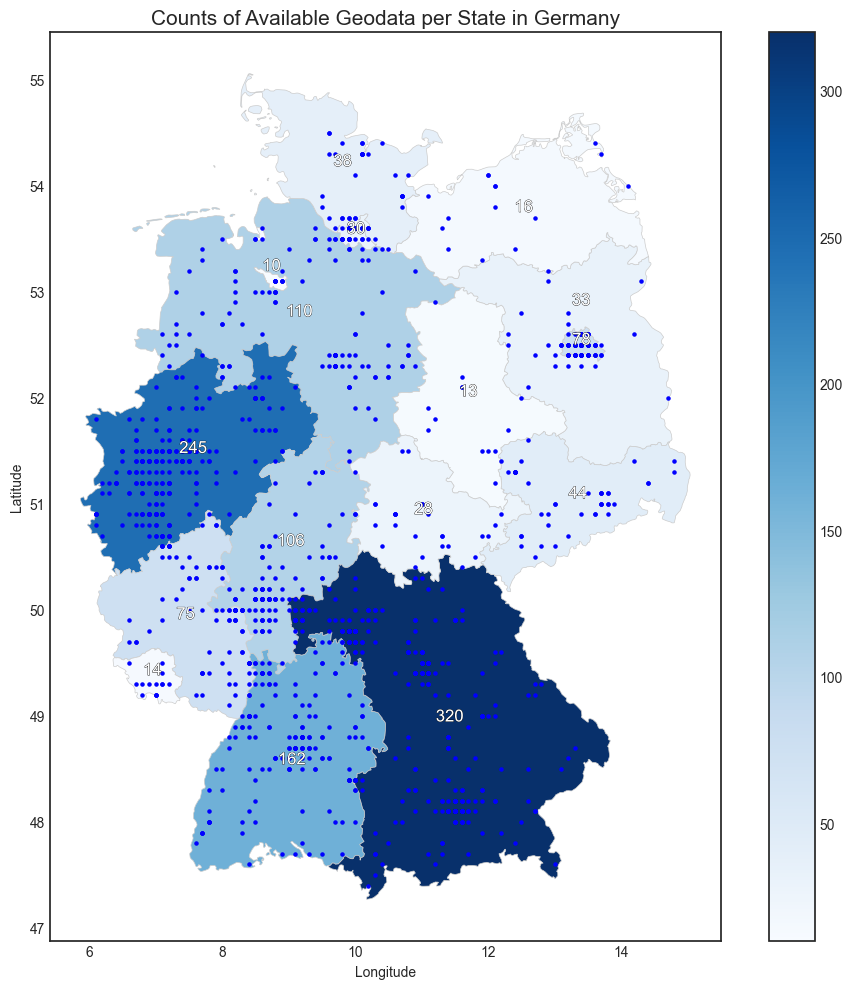

In [10]:
def plot_state_count_map(fig_name='state_count', scatter=False):

    # Ensure matplotlib is using the correct style
    plt.style.use('seaborn-v0_8-white')

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='Counts', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title('Counts of Available Geodata per State in Germany', fontsize=15)

    # Customize the text size
    text_size = 12

    # Annotate the centroids with the counts
    for idx, row in gdf.iterrows():
        # Adjustment of y as Berlin and Brandenburg overlay
        x, y = row['centroid'].x, row['centroid'].y + (0.4 if gdf.loc[idx,'GEN'] == 'Brandenburg' else 0)

        txt = plt.annotate(text=row['Counts'], xy=(x, y),
                     horizontalalignment='center', fontsize=text_size, color='white')

        # Outline effect
        txt.set_path_effects([PathEffects.withStroke(linewidth=.5, foreground='black')])
    # filter out NaN values
    sub_df = points_in_bundesland.dropna(subset=['GEN'])

    if scatter:
        #points_df = bl[['sensordata_latitude','sensordata_longitude']].dropna(how='any')
        ax.scatter(sub_df['lon'], sub_df['lat'],
               color='blue', s=5, label='Data Points')  # s is the size of pointser

    # Label the axes
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Remove the axes for a cleaner look, if preferred
    #ax.set_xticks([])
    #ax.set_yticks([])

    plt.tight_layout()

    # Optionally, keep the axes and set a grid
    plt.savefig(f'results/figures/{fig_name}.svg')

    plt.show()

plot_state_count_map(fig_name='count_state_scatter', scatter=True)

In [11]:
population_data_english = {
    "Baden-Wuerttemberg": 11339260,
    "Bavaria": 13435062,
    "Berlin": 3782202,
    "Brandenburg": 2581667,
    "Bremen": 691703,
    "Hamburg": 1910160,
    "Hesse": 6420729,
    "Mecklenburg-Vorpommern": 1629464,
    "Lower Saxony": 8161981,
    "North Rhine-Westphalia": 18190422,
    "Rhineland-Palatinate": 4174311,
    "Saarland": 994424,
    "Saxony": 4089467,
    "Saxony-Anhalt": 2180448,
    "Schleswig-Holstein": 2965691,
    "Thuringia": 2122335
}

pop_ser = pd.Series(population_data_english, name='population_data')

gdf = pd.merge(gdf, pop_ser, left_on='GEN', right_index=True)

In [15]:
gdf['user_engagement_permille'] = (gdf['Counts']*1000)/gdf['population_data']

In [20]:
res_df = gdf[['GEN','user_engagement_permille']].sort_values(by='user_engagement_permille')
print(res_df)

                       GEN  user_engagement_permille
13           Saxony-Anhalt                  0.005962
11  Mecklenburg-Vorpommern                  0.009819
12                  Saxony                  0.010759
10             Brandenburg                  0.012782
15      Schleswig-Holstein                  0.012813
14               Thuringia                  0.013193
3   North Rhine-Westphalia                  0.013469
1             Lower Saxony                  0.013477
8                 Saarland                  0.014079
6       Baden-Wuerttemberg                  0.014287
2                   Bremen                  0.014457
0                  Hamburg                  0.015705
4                    Hesse                  0.016509
5     Rhineland-Palatinate                  0.017967
9                   Berlin                  0.020623
7                  Bavaria                  0.023818
